In [1]:
# This a quick way to visualize the latest Hurricane wind data from HWRF 

In [1]:
#Import the neccessary modules

import numpy as np
from notebook import *
from ipywidgets import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
from mpl_toolkits.basemap import Basemap, shiftgrid
import glob
import urllib2,urllib
import os
import pandas
%matplotlib notebook

In [2]:
#Lookup the ftp server for the latest folder
path0='ftp://ftp.ncep.noaa.gov/pub/data/nccf/com/hur/prod/'
response=urllib2.urlopen(path0)
ls=response.readlines()
lp=[elem.strip() for elem in ls]


In [3]:
#choose the 4th folder (the latest) and isolate the name
fpath=lp[3].split()[-1]

In [4]:
# parse the folder 
fresponse=urllib2.urlopen(path0+fpath)
fls=fresponse.readlines()
flp=[elem.strip() for elem in fls]


In [5]:
w=['wind10m' in e for e in flp]

indx=[i for i, x in enumerate(w) if x]

indx

[534, 1064, 1594, 2124]

If it is more than one hur we choose ...

In [9]:
i=0 # change this one 
fname=flp[indx[i]].split()[-1]
fname

'haima25w.2016102100.wind10m.ascii'

In [10]:
#get hur name
hurName=fname.split('.')[0]
date=fname.split('.')[1]

In [11]:
# retrieve file
try:
    urllib.urlretrieve(path0+fpath+'/'+fname, filename='tmp/wind10m.txt')
except:
    print 'no such file'

In [12]:
#read file
r=pandas.read_csv('tmp/wind10m.txt',header=0)

The file has a header and in the end the track of the Hurricane. So we sort things out

We find the number of points included in the track

In [13]:
ntr=r.convert_objects(convert_numeric=True).dropna()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [14]:
ntr

,99.60 156.25 7.85 45.75 0.05 1134 759
860707,114.0


Now the values below line (see index on the left) is the track and above is the lat,lon, so

In [15]:
h=r.columns[0].split() # header

In [16]:
ntr.index[0]

860707

In [17]:
tra=r[ntr.index[0]+1:]

In [18]:
tr=[]
for x in tra.values.ravel():
    tr.append(x.split())

In [19]:
track=np.array(tr).astype(float)

In [20]:
dat=r[:ntr.index[0]] 

In [21]:
#s=data[data.columns[0]].apply(lambda x: pandas.Series(x.split(',')))

In [22]:
data=[]
for x in dat.values.ravel():
    data.append(x.split())

In [23]:
d=np.array(data)

In [24]:
lat=d[:-1,0].astype(float)
lon=d[:-1,1].astype(float)
windf=d[:-1,2].astype(float)

In [25]:
ni,nj=np.int(h[-1]),np.int(h[-2])

In [26]:
ni,nj

(759, 1134)

Reshape data to the shape given in the header

In [27]:
lat=lat.reshape(ni,nj) # the last 2 values of the header define grid size
lon=lon.reshape(ni,nj)
windf=windf.reshape(ni,nj)

In [28]:
lon

array([[  99.6 ,   99.65,   99.7 , ...,  156.15,  156.2 ,  156.25],
       [  99.6 ,   99.65,   99.7 , ...,  156.15,  156.2 ,  156.25],
       [  99.6 ,   99.65,   99.7 , ...,  156.15,  156.2 ,  156.25],
       ..., 
       [  99.6 ,   99.65,   99.7 , ...,  156.15,  156.2 ,  156.25],
       [  99.6 ,   99.65,   99.7 , ...,  156.15,  156.2 ,  156.25],
       [  99.6 ,   99.65,   99.7 , ...,  156.15,  156.2 ,  156.25]])

In order to make the plot better we can mask the NaN values (in this case -999.)

In [29]:
wind=np.ma.masked_where(windf == -999., windf)

In [30]:
#Define a personal cmap

wlevs = [30.,34.,50.,64.,83.,96.,114.,135.] #specify color map to match NOAA's HWRF
mwind=np.max(wlevs)
colors=['c','green','darkgreen','yellow','orange','r','brown']
cmap=mpl.colors.ListedColormap(colors)
norm=mpl.colors.BoundaryNorm(wlevs,cmap.N)

cmap.set_over(mpl.colors.colorConverter.to_rgb('m'))
cmap.set_under(mpl.colors.colorConverter.to_rgb('w'))

plot the figure

<IPython.core.display.Javascript object>


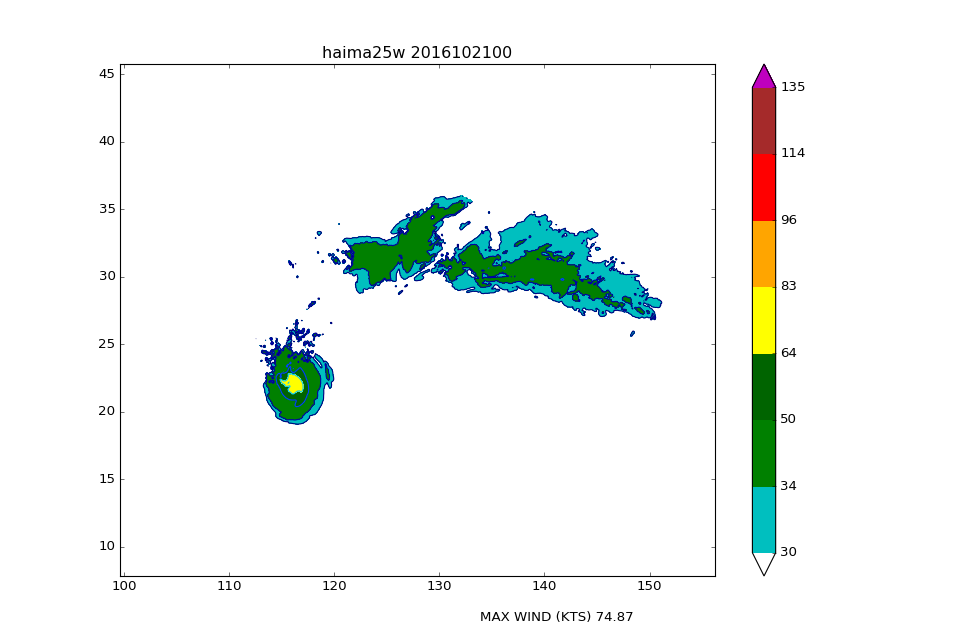

In [31]:

plt.figure(figsize=(12,8))
plt.contourf(lon,lat,wind,wlevs,cmap=cmap,norm=norm,boundaries=[0]+wlevs+[150.],extend='both')
plt.colorbar()
plt.contour(lon,lat,wind,wlevs)
plt.figtext(0.5,0.03,'MAX WIND (KTS) '+np.str(wind.max()))
#plt.plot(track[:,1],track[:,0],'k') # not the one printed on HWRF site
plt.savefig('wind10.png',transparent=True)
plt.title(hurName+' '+date)
plt.show()

In [32]:
from osgeo import gdal,gdal_array
import osr

dataTypeformat={1:np.byte,2:np.int32,3:np.int32,4:np.float32,5:np.float32,6:np.byte}
VSType={1:'VS_BOOLEAN',2:'VS_NOMINAL',3:'VS_ORDINAL',4:'VS_SCALAR',5:'VS_DIRECTION',6:'VS_LDD'}

def putmap(filename,var,geo,TYPE,nodata):
     driver=gdal.GetDriverByName('PCRaster')
     varw=var.astype(dataTypeformat[TYPE])
     gtype=gdal_array.NumericTypeCodeToGDALTypeCode(varw.dtype)
     NROWS,NCOLS = var.shape
     VS='PCRASTER_VALUESCALE={}'.format(VSType[TYPE])
     dst_ds=driver.Create(filename,NCOLS,NROWS,1,gtype,[VS])
     proj=osr.SpatialReference()
     proj.ImportFromEPSG(4326)
     dst_ds.SetProjection(proj.ExportToWkt())
     dst_ds.SetGeoTransform(geo)
     dst_ds.GetRasterBand(1).WriteArray(varw)
     dst_ds.GetRasterBand(1).SetNoDataValue(nodata)
     dst_ds.FlushCache()
     dst_ds=None
     return


In [33]:
SAVEPATH='/mnt/pandora/Users_Critech/Pamela/'
SAVEPATH='tmp/'

In [37]:
TYPE=4     
dd=lon[0,1]-lon[0,0]
print dd
geo=(lon.min(),dd,0,lat.max(),0, -dd)  
nodata=-999.
putmap(SAVEPATH+'wind10m'+hurName+date+'.tif',np.flipud(wind),geo,TYPE,nodata)


0.05
